In [1]:
import scipy as sp
from scipy import integrate
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

## Get r object, to perform R calls, and FloatVector to convert np array to R vector

In [2]:
r  = robjects.r
cf = robjects.FloatVector

## Get R libPaths and append the RStudio package location

In [3]:
libPaths=r[".libPaths"]

In [4]:
libPaths(robjects.StrVector([libPaths()[0], libPaths()[1], "D:/Documents/R/win-library/3.3"]))

R object with classes: ('character',) mapped to:
<StrVector - Python:0x000001EA06321E88 / R:0x000001EA0AA7CCD8>
['C:/Program Fi..., 'C:/Program Fi..., 'D:/Documents/...]

## Import stabledist to R

In [5]:
importr("stabledist")

rpy2.robjects.packages.Package as a <module 'stabledist'>

## Link dstable and qstable R funcs to python

In [6]:
levy     = r["dstable"]
quantile = r["qstable"]

## Plot Levy distributions

In [7]:
def PlotLevy(alphas, gammas, res=100, rng=[0.05, 0.95]):
    if type(alphas)==float or type(alphas)==int:
        alphas = [alphas]
    if type(gammas)==float or type(gammas)==int:
        gammas = [gammas]
    for alpha in alphas:
        for gamma in gammas:
            x = np.linspace( quantile(rng[0], alpha=alpha, gamma=gamma, beta=0)[0],
                             quantile(rng[1], alpha=alpha, gamma=gamma, beta=0)[0], res)
            y = np.array(levy(cf(x), alpha=alpha, gamma=gamma, beta=0))
            plt.figure(0, (14,7))
            plt.xlabel("x", fontsize=18)
            plt.ylabel("P(x)", fontsize=18)
            plt.plot(x,y, label=r"$\alpha=%.2f\;\; R=%.2f$"%(alpha, gamma))
    plt.legend(fontsize=18)

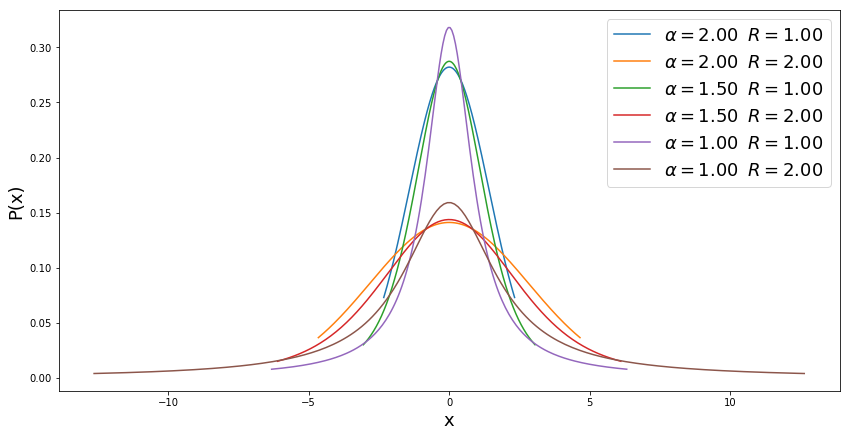

In [8]:
PlotLevy([2, 1.5, 1], [1,2], res=200)

# Calculate the Levy stable distribution

The distribution is defined by the following integral ($\frac{1}{2}$ comes from consistency in physics):
\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-\frac{1}{2}|\boldsymbol {q}R|^\alpha}
\end{equation}

The $\frac{1}{2}$ only appears in the equations, in acctual calculation I don't use, because in the true Levy distribution it's not there, and I want to compare the results.

### Levy parameters

In the following I will use: $\alpha=0.7$ and $R=3$.

## MCMC Metropolis algorithm

In [13]:
def mcmc_1d(num_samples, f, fpars, pi, ppars, proposal_sigma=1.0):
    xi = np.random.uniform()
    s  = f(xi, *fpars)-f(xi, *fpars)
    for i in range(num_samples):
        xg = np.random.normal(xi, proposal_sigma)
        if np.random.uniform()<pi(xg, *ppars)/pi(xi, *ppars):
            xi = xg
        s += f(xi, *fpars)
    return s/float(num_samples)

## 1D

I want to calculate $I=\int f(x)p(x) dx$, integral, where $f(x)\propto e^{ixr}$ and $p(x)\propto e^{-|xR|^\alpha}$. I use the $p(x)$ distribution for sampling, the normalization factor $\int p(x)dx=C$, so 
\begin{equation}
I = C\int f(x)\frac{p(x)}{C} dx
\end{equation}

In [11]:
def f(x, r, alpha, R):
    return np.exp(1j*np.dot(x,r))

# the sampling probability distribution
def p(x, alpha, R):
    return np.exp(-np.power(np.linalg.norm(x)*R, alpha) )

# calls for mcmc_1d and do the scaling with C/2pi
def Levy1D_MCMC(r, alpha, R, num_samples):
    C = integrate.quad(p, -np.inf, np.inf, args=(alpha, R))[0]
    return C*mcmc_1d(num_samples, f, (r, alpha, R), p, (alpha, R))/(2*np.pi)

# scipy numerical integration
def Levy_int(r, alpha, R):
    return integrate.quad(lambda x: f(x, r, alpha,R).real*p(x,alpha,R), -np.inf, np.inf)[0]/(2*np.pi)

### MCMC integration

The path length is $\large{10000}$.

In [11]:
start = time.time()
x = np.linspace(-10,10,30)
y = [Levy1D_MCMC(q, 0.7, 3, 10000) for q in x]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:5.85


#### 5.73s until 30 MCMC completed (every MCMC had 10000 length path)

### Scipy numerical integration

In [13]:
start = time.time()
x1 = np.linspace(-10,10,309)
y1 = [Levy_int(q, 0.7, 3) for q in x1]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:4.88


### Plot

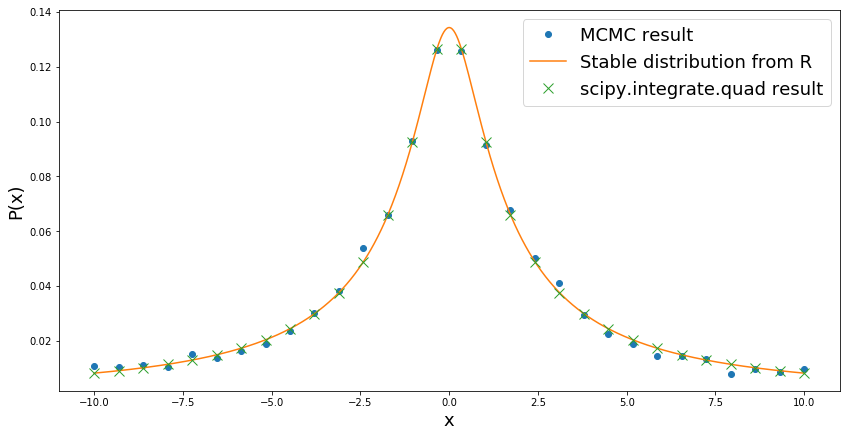

In [13]:
plt.figure(0,(14,7))
plt.xlabel("x", fontsize=18)
plt.ylabel("P(x)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
x2 = np.linspace(-10,10,1000)
y2 = np.array(levy(cf(x2), alpha=0.7, gamma=3, beta=0))
plt.plot(x2,y2, label="Stable distribution from R")
plt.plot(x1,y1, 'x', markersize=10, label="scipy.integrate.quad result")
plt.legend(fontsize=18)

## 3D, $\boldsymbol{r}=(0,0,r)$

Let: $\boldsymbol{r}=(0,0,r)$, then the integral above becomes:
\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{4\pi}{(2\pi)^3}\int_0^\infty \frac{q\sin{qr}}{r}e^{-\frac{1}{2}|qR|^\alpha}dq
\end{equation}

This means only $f(x)$ and the scaling parameter changes. The integral can be written in the following form:
\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{2}\frac{4\pi}{(2\pi)^3}\int_{-\infty}^\infty \frac{q\sin{qr}}{r}e^{-\frac{1}{2}|qR|^\alpha}dq
\end{equation}

In [33]:
# the new f function
def f3D(x, r, alpha, R):
    return x*np.sin(x*r)/r

# the 3D levy MCMC changed f and norm factor
def Levy3D_spec_MCMC(r, alpha, R, num_samples):
    C = integrate.quad(p, -np.inf, np.inf, args=(alpha, R))[0]
    return 4*np.pi*C*mcmc_1d(num_samples, f3D, (r, alpha, R), p, (alpha, R))/(2*np.pi)**3  / 2

In [17]:
# The full function to integrate (for scipy)
def fLevy3D(x, r, alpha, R):
    return 4*np.pi*(x*np.sin(x*r)/r)*np.exp(-np.power(np.linalg.norm(x)*R, alpha))/(2*np.pi)**3

### MCMC integration

The path length is $\large{10000}$. And I calculate in $40$ $r$ bins.

In [41]:
start = time.time()
x = np.linspace(-10,10,40)
y = [Levy3D_spec_MCMC(q, 0.7, 3, 10000) for q in x]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:7.15


#### 7.73s until 40 MCMC completed (every MCMC had 10000 length path)

### Scipy integration

In [42]:
start = time.time()
x1 = np.linspace(-10,10,600)
y1 = np.array([integrate.quad(fLevy3D, 0, np.inf, args=(q, 0.7, 3))[0] for q in x1])
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:2.41


### Plot

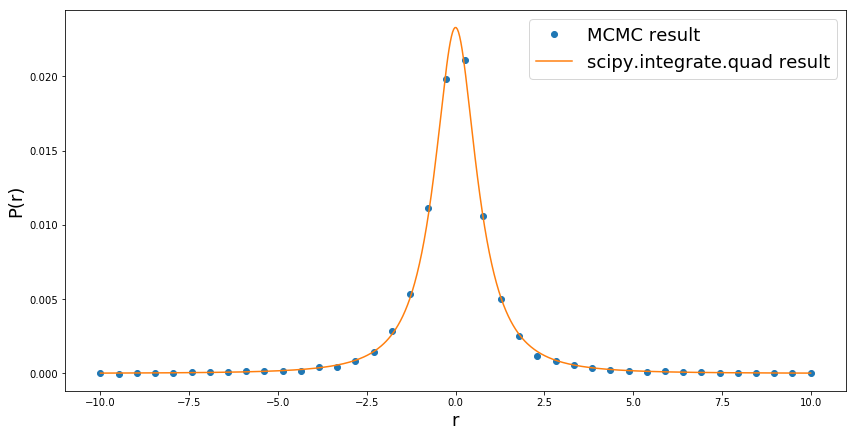

In [43]:
plt.figure(0,(14,7))
plt.xlabel("r", fontsize=18)
plt.ylabel("P(r)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
plt.plot(x1,y1, label="scipy.integrate.quad result")
plt.legend(fontsize=18)

## 3D

In [23]:
def p_3d(q, alpha, R):
    return np.exp(-np.power(np.linalg.norm(q)*R, alpha))

def f_3d(q, r):
    return np.exp(1j*np.dot(q,r))

In [32]:
def mcmc_3d(num_samples, f, pi, fpars,pipars, proposal_sigma = [1.0, 1.0, 1.0]):
    xi = np.random.uniform(-1,1,3)
    s  = f(xi, *fpars)-f(xi, *fpars)
    for i in range(num_samples):
        xg = np.random.normal(xi, proposal_sigma)
        if np.random.uniform()<pi(xg, *pipars)/pi(xi, *pipars):
            xi = xg
        s += f(xi, *fpars)
    return s/float(num_samples)

In [56]:
# the 3D levy MCMC changed f and norm factor
def Levy3D_MCMC(r, alpha, R, num_samples):
    C = 4*np.pi*integrate.quad(p, 0, np.inf, args=(alpha, R))[0]
    return C*mcmc_3d(num_samples, f_3d, p_3d, (r,), (alpha, R))/(2*np.pi)**3

In [57]:
start = time.time()
x_3d = np.linspace(-10,10,40)
y_3d = [Levy3D_MCMC(np.array([0,0,q]), 0.7, 3, 10000) for q in x]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:10.60


C:\Users\qati\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


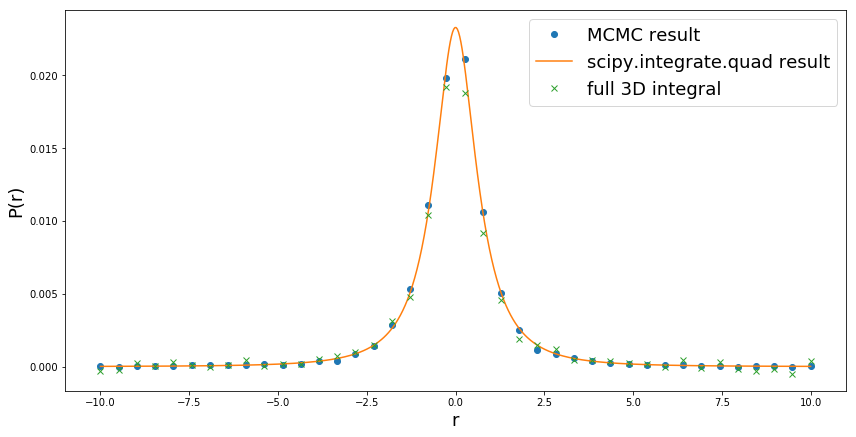

In [58]:
plt.figure(0,(14,7))
plt.xlabel("r", fontsize=18)
plt.ylabel("P(r)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
plt.plot(x1,y1, label="scipy.integrate.quad result")
plt.plot(x_3d,np.array(y_3d),'x', label="full 3D integral")
plt.legend(fontsize=18)

In [59]:
start = time.time()
x_3d_2 = np.linspace(-10,10,40)
y_3d_2 = [Levy3D_MCMC(np.array([0,q,0]), 0.7, 3, 10000) for q in x]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:11.54


C:\Users\qati\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


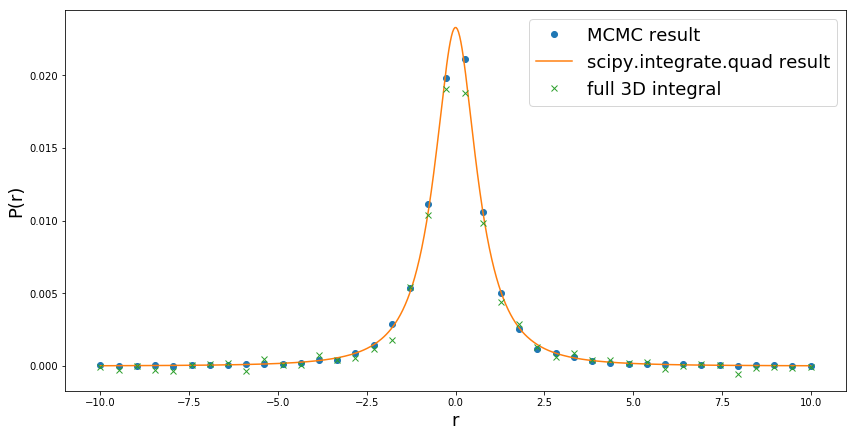

In [62]:
plt.figure(0,(14,7))
plt.xlabel("r", fontsize=18)
plt.ylabel("P(r)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
plt.plot(x1,y1, label="scipy.integrate.quad result")
plt.plot(x_3d_2,np.array(y_3d_2),'x', label="full 3D integral")
plt.legend(fontsize=18)

In [63]:
start = time.time()
x_3d_3 = np.linspace(-10,10,40)
y_3d_3 = [Levy3D_MCMC(np.array([q/np.sqrt(3),q/np.sqrt(3),q/np.sqrt(3)]), 0.7, 3, 10000) for q in x]
rt  = time.time()-start
print("Seconds:%.2f"%rt)

Seconds:11.28


C:\Users\qati\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


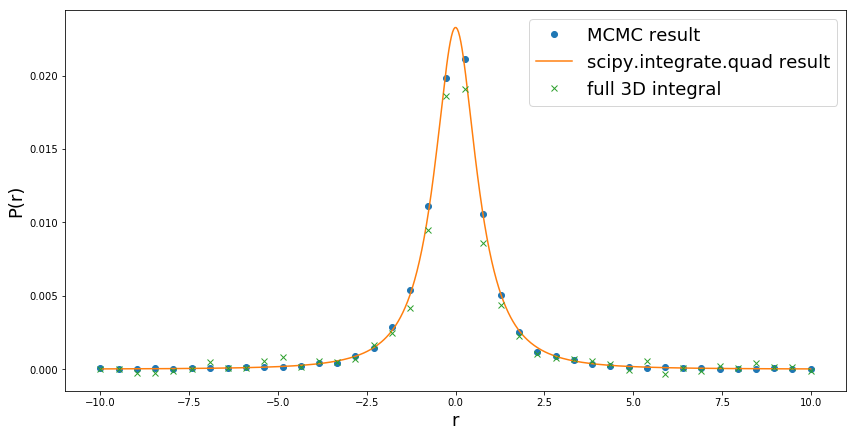

In [64]:
plt.figure(0,(14,7))
plt.xlabel("r", fontsize=18)
plt.ylabel("P(r)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
plt.plot(x1,y1, label="scipy.integrate.quad result")
plt.plot(x_3d_3,np.array(y_3d_3),'x', label="full 3D integral")
plt.legend(fontsize=18)